In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Ellipse

from scipy.interpolate import griddata

plt.rcParams.update({'font.size': 12})

np.random.seed(4)

from scipy import stats
from scipy.stats import norm, uniform
import scipy.optimize

In [2]:
# import internal files
import emulator
import kernels
import data
import historymatch
import plot

In [3]:
def model_eqn_1(x, theta_0, theta_1, theta_2):
    return theta_0 + theta_1*(x) + theta_2*(x**2)

#def model_eqn_1(x, theta_0, theta_1):
    #return theta_0 + theta_1*(x)
    
function1 = np.vectorize(model_eqn_1)

In [4]:
#def model_eqn_2(x, theta_0, theta_1):
    #return theta_0 - theta_1*np.sin(x)

def model_eqn_2(x, theta_0, theta_1, theta_2):
    return theta_0 - theta_1*np.sin(x) + theta_2*np.cos(x)

function2 = np.vectorize(model_eqn_2)

In [5]:
# define parameter space
x_bound = np.array([0.1, 1])
Nx = 4
xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound), axis=0)

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)

#theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1)), axis=0)

In [6]:
# for testing: true datapoints
true_parameters = [-0.1, 0.3, 0.6]
ndim = len(true_parameters)

var_exp_f1 = 0.001        # observational uncertainty variance
var_exp_f2 = 0.001

error_f1 = np.random.normal(0, var_exp_f1, len(xvals))
error_f2 = np.random.normal(0, var_exp_f2, len(xvals))

#z_1 = function1(xvals, true_parameters[0], true_parameters[1], true_parameters[2])+ np.random.normal(0, var_exp_f1) # observed datapoint
z_1 = function1(xvals, true_parameters[0], true_parameters[1], true_parameters[2]) + error_f1 # observed datapoint

z_2 = function2(xvals, true_parameters[0], true_parameters[1], true_parameters[2]) + error_f2  # observed datapoint

#z_1 = function1(xvals, true_parameters[0], true_parameters[1]) + error_f1 # observed datapoint
#z_2 = function2(xvals, true_parameters[0], true_parameters[1]) + error_f2  # observed datapoint



Text(0, 0.5, '$z_{2}$')

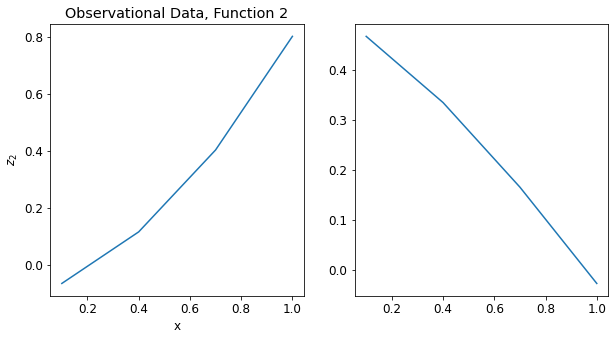

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))


ax1.plot(xvals, z_1)
ax2.plot(xvals, z_2)

ax1.set_title('Observational Data, Function 1')
ax1.set_title('Observational Data, Function 2')

ax1.set_xlabel('x')
ax1.set_ylabel(r'$z_{1}$')
ax1.set_xlabel('x')
ax1.set_ylabel(r'$z_{2}$')

In [8]:
def design_matrix_f1(x, p=3):
    X_d = np.zeros((len(x),p))
    for i in range(p):
        X_d[:,i] = x**i
    return X_d

def design_matrix_f2(x, p=3):
    X_d = np.zeros((len(x),p))
    X_d[:,0] = 1
    X_d[:,1] = -np.sin(x)
    X_d[:,2] = np.cos(x)
    return X_d


# Create design matrix
X1 = design_matrix_f1(xvals, p=3)
X2 = design_matrix_f2(xvals, p=3)


In [9]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [10]:
A1 = A_matrix(X1, var_exp_f1)
b1 = z_1 / np.sqrt(var_exp_f1)

A2 = A_matrix(X2, var_exp_f2)
b2 = z_2 / np.sqrt(var_exp_f2)

In [11]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [12]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

In [13]:
def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [14]:
cov_matrix_f1 = covariance(X1, var_exp_f1)
cov_matrix_f2 = covariance(X2, var_exp_f2)
theta_f1 = solve_theta(A1, b1)
theta_f2 = solve_theta(A2, b2)

true_thetas = [theta_f1, theta_f2]


H1 = H_matrix(A1)
H2 = H_matrix(A2)


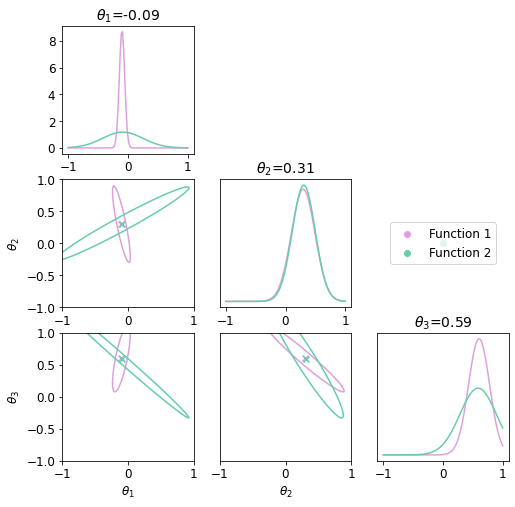

In [15]:
color_list = ['plum', 'mediumaquamarine']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(8,8))

ax = fig.axes[5]
plot.plot_ellipses(fig, parameter_bounds, true_parameters, H1, theta_f1, theta_vals, color_list[0])
plot.plot_ellipses(fig, parameter_bounds, true_parameters, H2, theta_f2, theta_vals, color_list[1])
ax.scatter(1,1,color=color_list[0],label='Function 1')
ax.scatter(1,1,color=color_list[1],label='Function 2')
ax.legend(loc='center')

In [16]:
# create squared-exponential kernel
sigma_cov = 0.1        # sqrt variance of covariance function
beta = 0         # prior expectation
theta = 1
var_method=0

sigma_n = 0.1

kern = kernels.SE()

# simulation parameters
Ntraining = 30          # number of training points
ndim = 3    # model dimensions
Nsamples = 5000    # number of test points

#true_model = [model_eqn_1]
true_model = [model_eqn_1, model_eqn_2]
#obs_data = z_1.reshape(1,-1)
obs_data = np.concatenate((z_1.reshape(1,-1),z_2.reshape(1,-1)), axis=0)


Current wave: 1
5
Current wave: 2
4
Current wave: 3
1


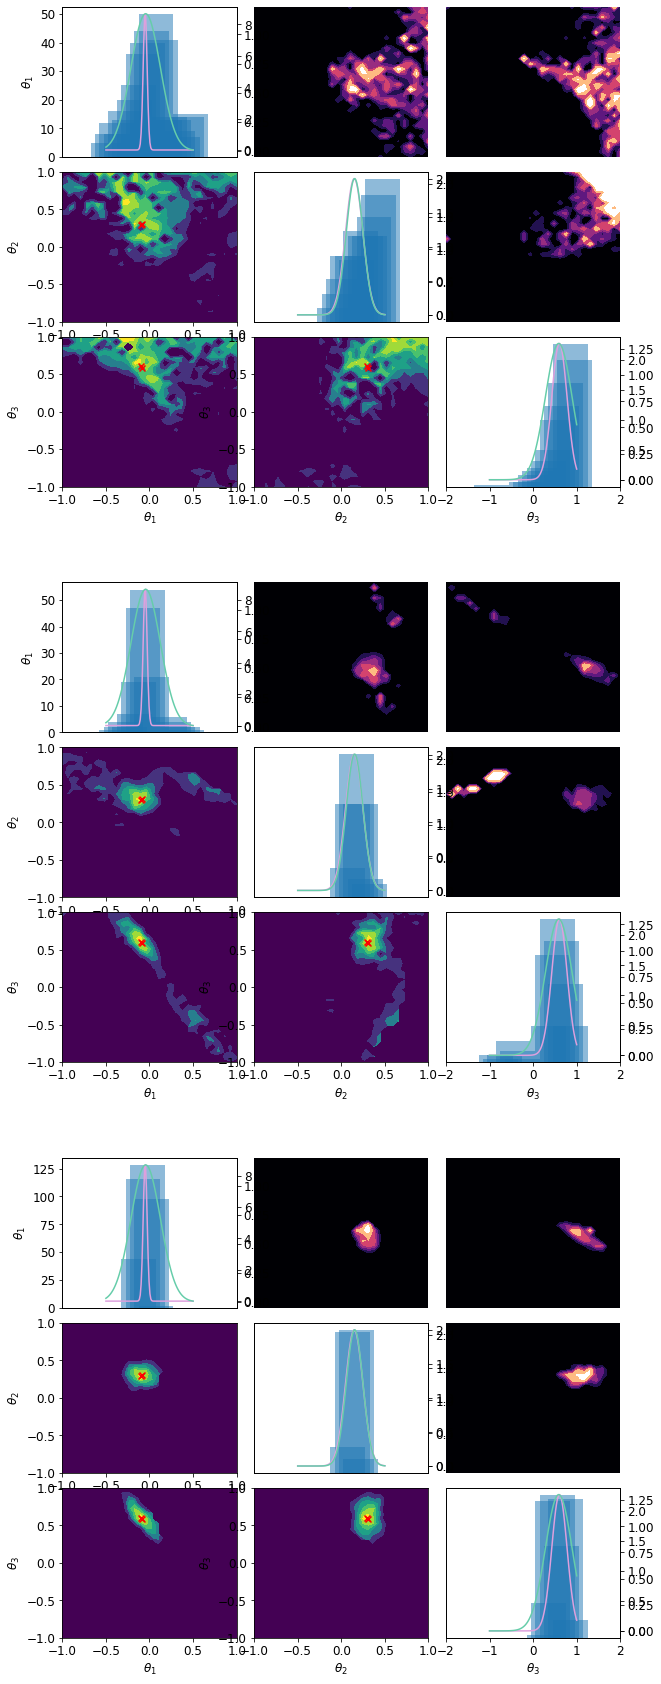

In [17]:
n_waves = 3


ctr, cov, nonimp, ell = historymatch.history_match(true_model, obs_data, xvals, kern, ndim, Nsamples, Ntraining,
                           parameter_bounds, var_method, var_exp_f1, sigma_cov,
                           beta, theta, sigma_n, [H1,H2], true_thetas,
                           noise=False, waves=n_waves)

In [18]:
def plot_ellipsoid_3d(ell, ax):
    """Plot the 3-d Ellipsoid ell on the Axes3D ax."""

    # points on unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    z = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    x = np.outer(np.ones_like(u), np.cos(v))

    # transform points to ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j], y[i,j], z[i,j] = ell.ctr + np.dot(ell.axes,
                                                      [x[i,j],y[i,j],z[i,j]])

    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='#2980b9', alpha=0.2)